In [2]:
import pandas as pd
import wandb
import numpy as np 
import matplotlib.pyplot as plt

api = wandb.Api()

def extract_project_data(project, entity='[WANDB USERNAME]'):
    runs = api.runs(entity + "/" + project)
    summary_list, config_list, name_list, histories = [], [], [], []
    for run in runs:
        summary_list.append(run.summary._json_dict)
        config_list.append(
            {k: v for k,v in run.config.items()
             if not k.startswith('_')})
        name_list.append(run.name)
        histories.append(run.history())
    return summary_list, config_list, name_list, histories


# No exploration phase

In [3]:
project_data = {}
for env in ['disease', 'glucose', 'windygrid']:
    project = f'{env}_FINAL'
    project_data[env] = extract_project_data(project)

In [4]:
runs_dfs = {}
for env, pdata in project_data.items():
    summary_list, config_list, name_list, histories = pdata
    
    rewards = []
    max_est_errs = []
    mean_est_errs = []
    to_delete = []
    for i, history in enumerate(histories):
        if len(history) == 0:
            to_delete.append(i)
            continue
        reward = history[['_step', 'Per-Episode Reward']].set_index('_step')
        reward = (reward.dropna().rolling(window=10).mean().reindex(reward.index, method='pad'))
        rewards.append(reward)
        
        if 'Transition Max L1 Error' in history.columns:
            est_err = history[['_step', 'Transition Max L1 Error']].set_index('_step')
            est_err = (est_err.dropna().rolling(window=10).mean().reindex(est_err.index, method='pad'))
            max_est_errs.append(est_err)

        if 'Transition Mean L1 Error' in history.columns:
            est_err = history[['_step', 'Transition Mean L1 Error']].set_index('_step')
            est_err = (est_err.dropna().rolling(window=10).mean().reindex(est_err.index, method='pad'))
            mean_est_errs.append(est_err)

    summary_list = [s for (i, s) in enumerate(summary_list) if i not in to_delete]
    config_list = [c for (i, c) in enumerate(config_list) if i not in to_delete]
    name_list = [n for (i, n) in enumerate(name_list) if i not in to_delete]
    
    runs_df = {
        "summary": summary_list,
        "config": config_list,
        "name": name_list,
        "rewards": rewards,
    }
    if max_est_errs:
        runs_df['max_est_errs'] = max_est_errs
    if mean_est_errs:
        runs_df['mean_est_errs'] = mean_est_errs
    runs_df = pd.DataFrame(runs_df)
    runs_dfs[env] = runs_df

In [5]:
runs_dfs['windygrid']

,summary,config,name,rewards,max_est_errs,mean_est_errs
0,"{'Q': {'height': 2100, 'sha256': '1514e5190e6a...","{'env': 'custom_windygrid', 'tag': 'custom_win...",06-26-2023_18:16:50_model_free,Per-Episode Reward _step ...,Transition Max L1 Error _step ...,Transition Mean L1 Error _step ...
1,"{'Q': {'height': 2100, 'sha256': 'eab9b4313a4c...","{'env': 'custom_windygrid', 'tag': 'custom_win...",06-26-2023_18:16:50_timing_dumb,Per-Episode Reward _step ...,Transition Max L1 Error _step ...,Transition Mean L1 Error _step ...
2,"{'Transition Avg NLL': 1.6785455743471782, 'R'...","{'env': 'custom_windygrid', 'tag': 'custom_win...",06-26-2023_18:16:50_timing_smart,Per-Episode Reward _step ...,Transition Max L1 Error _step ...,Transition Mean L1 Error _step ...
3,"{'Episode Length': 50, 'Reward Lookups': {'bin...","{'env': 'custom_windygrid', 'tag': 'custom_win...",06-25-2023_18:34:27_model_free,Per-Episode Reward _step ...,Transition Max L1 Error _step ...,Transition Mean L1 Error _step ...
4,"{'Q': {'size': 1540517, '_type': 'image-file',...","{'env': 'custom_windygrid', 'tag': 'custom_win...",06-25-2023_18:34:27_timing_dumb,Per-Episode Reward _step ...,Transition Max L1 Error _step ...,Transition Mean L1 Error _step ...
...,...,...,...,...,...,...
150,{'Distribution of Actions': {'_type': 'image-f...,"{'env': 'custom_windygrid', 'tag': 'custom_win...",05-10-2023_13:41:33_timing_smart,Per-Episode Reward _step ...,Transition Max L1 Error _step ...,Transition Mean L1 Error _step ...
151,"{'Transition Avg NLL': 'NaN', '_step': 210, '_...","{'env': 'custom_windygrid', 'tag': 'custom_win...",05-09-2023_20:28:48_model_free,Per-Episode Reward _step ...,Transition Max L1 Error _step ...,Transition Mean L1 Error _step ...
152,{'R': {'path': 'media/images/R_210_5cbc553fed1...,"{'env': 'custom_windygrid', 'tag': 'custom_win...",05-09-2023_20:28:48_timing_dumb,Per-Episode Reward _step ...,Transition Max L1 Error _step ...,Transition Mean L1 Error _step ...
153,"{'Distribution of Actions': {'size': 130865, '...","{'env': 'custom_windygrid', 'tag': 'custom_win...",05-09-2023_20:28:48_timing_smart,Per-Episode Reward _step ...,Transition Max L1 Error _step ...,Transition Mean L1 Error _step ...


In [6]:
def get_final_returns(runs_df):
    runs = runs_df.copy()
    runs['method'] = runs.apply(lambda row: '_'.join(row['name'].split('_')[-2:]), axis=1)
    runs['per_episode_return'] = runs.apply(lambda row: row.summary['Per-Episode Reward'], axis=1)
    runs = runs.set_index('name')
    returns = runs.groupby('method').describe()['per_episode_return']
    returns['low'] = returns['mean'] - 1.69 * (returns['std'] / np.sqrt(returns['count']))
    returns['high'] = returns['mean'] + 1.69 * (returns['std'] / np.sqrt(returns['count']))
    returns = returns[['mean', 'low', 'high']]
    return returns

def plot_metrics(runs_df, ax, metric='rewards', title=None, xlabel=None, sci=False, colors=None, label_override=None):
    names = {
        'timing_smart': 'Timing-Aware',
        'timing_dumb': 'Timing-Naive',
        'model_free': 'Model-Free',
    }
    if colors is None:
        colors = {
            'timing_smart': 'tab:green',
            'timing_dumb': 'tab:orange',
            'model_free': 'tab:blue',
        }
    runs = runs_df.copy()
    runs['method'] = runs.apply(lambda row: '_'.join(row['name'].split('_')[-2:]), axis=1)
    method_to_vals = {}
    for method in runs['method'].unique():
        if metric in ['max_est_errs', 'mean_est_errs'] and method == 'model_free':
            continue
        mruns = runs[runs['method'] == method]
        mruns = pd.concat(mruns[metric].tolist(), axis=1)
        mruns = mruns.agg(['mean','std', 'count'], axis=1)

        if label_override:
            ax.plot(mruns['mean'], label=label_override, color=colors[method])
        else:
            ax.plot(mruns['mean'], label=names[method], color=colors[method])
        ax.fill_between(
            mruns.index,
            mruns['mean'] - (mruns['std'] / np.sqrt(mruns['count'])), 
            mruns['mean'] + (mruns['std'] / np.sqrt(mruns['count'])), 
            alpha=0.1,
            color=colors[method])
        ax.set_title(title, fontsize=18)
        ax.set_xlabel(xlabel, fontsize=14)
        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=14)

        if sci and mruns['mean'].max() > 100:
            ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
        
        method_to_vals[method] = mruns['mean'], mruns['std'], mruns['count']
    return method_to_vals

In [14]:
for env, runs_df in runs_dfs.items():
    display(get_final_returns(runs_df))

,mean,low,high
method,,,
model_free,299.690909,252.371961,347.009858
timing_dumb,390.651053,325.541255,455.760850
timing_smart,378.683593,322.800330,434.566855


,mean,low,high
method,,,
model_free,24.346147,16.329269,32.363025
timing_dumb,34.974326,23.757805,46.190847
timing_smart,40.770930,26.753090,54.788769


,mean,low,high
method,,,
model_free,486.253474,31.181884,941.325064
timing_dumb,7400.755211,6673.743908,8127.766514
timing_smart,7704.426553,7160.651877,8248.201229


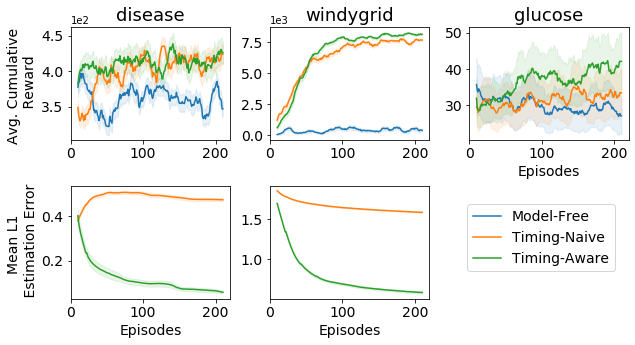

In [8]:
fig, axes = plt.subplots(2, 3, figsize=(10, 5))
envs = ['disease', 'windygrid', 'glucose']
for i, env in enumerate(envs):
    runs_df = runs_dfs[env]
    method_to_vals = plot_metrics(runs_df, axes[0][i], metric='rewards', title=env, xlabel=None, sci=True)
    
for i, env in enumerate(envs):
    if env == 'glucose':
        continue
    runs_df = runs_dfs[env]
    plot_metrics(runs_df, axes[1][i], metric='mean_est_errs', title=None, xlabel='Episodes')

axes[0][0].set_ylabel('Avg. Cumulative \n Reward', fontsize=14)
axes[1][0].set_ylabel('Mean L1 \n Estimation Error', fontsize=14)
axes[0][2].set_xlabel('Episodes', fontsize=14)

plt.subplots_adjust(hspace=0.4, wspace=0.25)
fig.delaxes(axes[-1, -1])
axes[0, -1].legend(loc='upper center', bbox_to_anchor=(0.45, -0.5), fontsize=14)
plt.savefig('learning_curves.pdf', dpi=300)
# plt.tight_layout()

# Exploration phase

In [9]:
explore_project_data = {}
for env in ['disease', 'glucose', 'windygrid']:
    project = f'{env}_EXPLORE_FINAL'
    explore_project_data[env] = extract_project_data(project)

In [10]:
explore_runs_dfs = {}
for env, pdata in explore_project_data.items():
    summary_list, config_list, name_list, histories = pdata
    
    rewards = []
    max_est_errs = []
    mean_est_errs = []
    to_delete = []
    for i, history in enumerate(histories):
        if len(history) == 0:
            to_delete.append(i)
            continue
        reward = history[['_step', 'Per-Episode Reward']].set_index('_step')
        reward = (reward.dropna().rolling(window=10).mean().reindex(reward.index, method='pad'))
        rewards.append(reward)
        
        if 'Transition Max L1 Error' in history.columns:
            est_err = history[['_step', 'Transition Max L1 Error']].set_index('_step')
            est_err = (est_err.dropna().rolling(window=10).mean().reindex(est_err.index, method='pad'))
            max_est_errs.append(est_err)

        if 'Transition Mean L1 Error' in history.columns:
            est_err = history[['_step', 'Transition Mean L1 Error']].set_index('_step')
            est_err = (est_err.dropna().rolling(window=10).mean().reindex(est_err.index, method='pad'))
            mean_est_errs.append(est_err)

    summary_list = [s for (i, s) in enumerate(summary_list) if i not in to_delete]
    config_list = [c for (i, c) in enumerate(config_list) if i not in to_delete]
    name_list = [n for (i, n) in enumerate(name_list) if i not in to_delete]
    
    runs_df = {
        "summary": summary_list,
        "config": config_list,
        "name": name_list,
        "rewards": rewards,
    }
    if max_est_errs:
        runs_df['max_est_errs'] = max_est_errs
    if mean_est_errs:
        runs_df['mean_est_errs'] = mean_est_errs
    runs_df = pd.DataFrame(runs_df)
    explore_runs_dfs[env] = runs_df

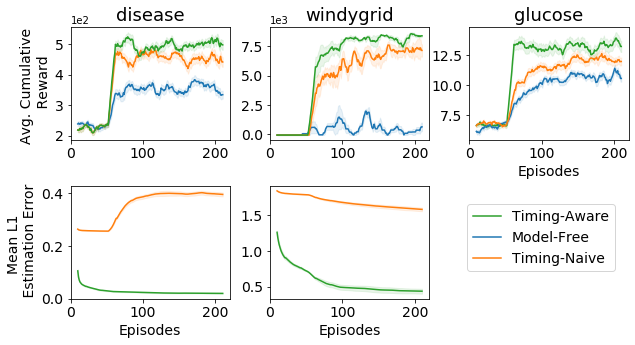

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(10, 5))
envs = ['disease', 'windygrid', 'glucose']
for i, env in enumerate(envs):
    runs_df = explore_runs_dfs[env]
    plot_metrics(runs_df, axes[0][i], metric='rewards', title=env, xlabel=None, sci=True)
    
for i, env in enumerate(envs):
    if env == 'glucose':
        continue
    runs_df = explore_runs_dfs[env]
    plot_metrics(runs_df, axes[1][i], metric='mean_est_errs', title=None, xlabel='Episodes')

axes[0][0].set_ylabel('Avg. Cumulative \n Reward', fontsize=14)
axes[1][0].set_ylabel('Mean L1 \n Estimation Error', fontsize=14)
axes[0][2].set_xlabel('Episodes', fontsize=14)

plt.subplots_adjust(hspace=0.4, wspace=0.25)
fig.delaxes(axes[-1, -1])
axes[0, -1].legend(loc='upper center', bbox_to_anchor=(0.45, -0.5), fontsize=14)
plt.savefig('explore_learning_curves.pdf', dpi=300)
# plt.tight_layout()

In [12]:
get_final_returns(explore_runs_df)

NameError: name 'explore_runs_df' is not defined

# Compare timing smart explore vs. not

disease
windygrid
glucose


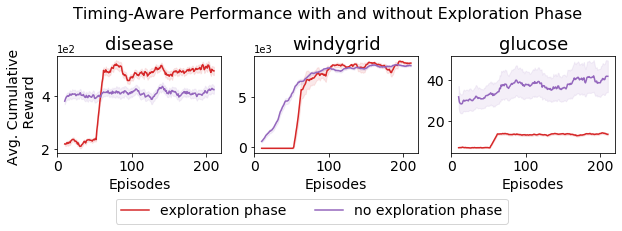

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4.5))
for i, env in enumerate(envs):
    print(env)
    explore_df = explore_runs_dfs[env].copy()
    not_explore_df = runs_dfs[env].copy()

    explore_df['method'] = explore_df.apply(lambda row: '_'.join(row['name'].split('_')[-2:]), axis=1)
    not_explore_df['method'] = not_explore_df.apply(lambda row: '_'.join(row['name'].split('_')[-2:]), axis=1)

    explore_df = explore_df[explore_df['method'] == 'timing_smart']
    not_explore_df = not_explore_df[not_explore_df['method'] == 'timing_smart']

    plot_metrics(explore_df, axes[i], metric='rewards', title=env, xlabel=None, sci=True, colors={'timing_smart': 'tab:red','timing_dumb': 'tab:red'}, label_override='exploration phase')
    plot_metrics(not_explore_df, axes[i], metric='rewards', title=env, xlabel=None, sci=True, colors={'timing_smart': 'tab:purple','timing_dumb': 'tab:purple'}, label_override='no exploration phase')
axes[0].set_ylabel('Avg. Cumulative \n Reward', fontsize=14)
axes[0].set_xlabel('Episodes', fontsize=14)
axes[1].set_xlabel('Episodes', fontsize=14)
axes[2].set_xlabel('Episodes', fontsize=14)
axes[1].legend(loc='upper center', bbox_to_anchor=(0.35, -0.4), ncol=2, fontsize=14)
# axes[-1].legend()
fig.suptitle('Timing-Aware Performance with and without Exploration Phase', fontsize=16, y=0.95)
plt.subplots_adjust(bottom=0.5, top=0.8)

plt.savefig('timing_smart_exploration.pdf', dpi=300)

disease
windygrid


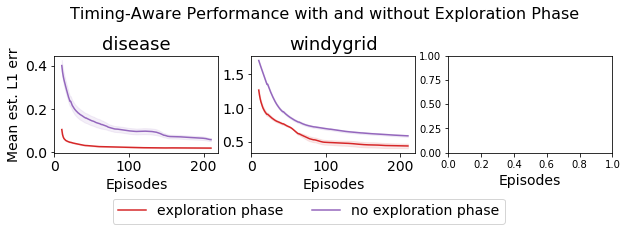

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4.5))
for i, env in enumerate(envs):
    if env == 'glucose':
        continue
    print(env)
    explore_df = explore_runs_dfs[env].copy()
    not_explore_df = runs_dfs[env].copy()

    explore_df['method'] = explore_df.apply(lambda row: '_'.join(row['name'].split('_')[-2:]), axis=1)
    not_explore_df['method'] = not_explore_df.apply(lambda row: '_'.join(row['name'].split('_')[-2:]), axis=1)

    explore_df = explore_df[explore_df['method'] == 'timing_smart']
    not_explore_df = not_explore_df[not_explore_df['method'] == 'timing_smart']

    plot_metrics(explore_df, axes[i], metric='mean_est_errs', title=env, xlabel=None, sci=True, colors={'timing_smart': 'tab:red','timing_dumb': 'tab:red'}, label_override='exploration phase')
    plot_metrics(not_explore_df, axes[i], metric='mean_est_errs', title=env, xlabel=None, sci=True, colors={'timing_smart': 'tab:purple','timing_dumb': 'tab:purple'}, label_override='no exploration phase')
axes[0].set_ylabel('Mean est. L1 err', fontsize=14)
axes[0].set_xlabel('Episodes', fontsize=14)
axes[1].set_xlabel('Episodes', fontsize=14)
axes[2].set_xlabel('Episodes', fontsize=14)
axes[1].legend(loc='upper center', bbox_to_anchor=(0.35, -0.4), ncol=2, fontsize=14)
# axes[-1].legend()
fig.suptitle('Timing-Aware Performance with and without Exploration Phase', fontsize=16, y=0.95)
plt.subplots_adjust(bottom=0.5, top=0.8)
plt.savefig('timing_smart_exploration.pdf', dpi=300)

disease
windygrid
glucose
disease
windygrid


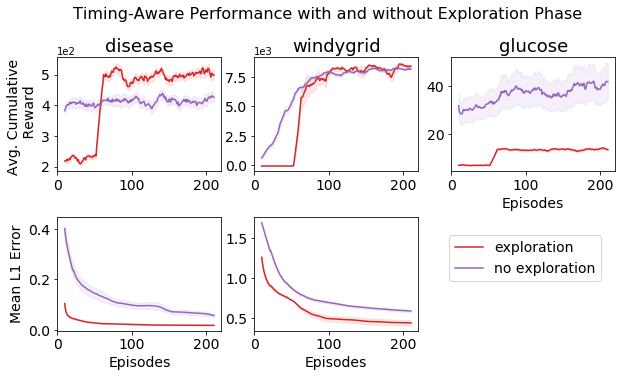

In [39]:
fig, axes = plt.subplots(2, 3, figsize=(10, 10))
for i, env in enumerate(envs):
    print(env)
    explore_df = explore_runs_dfs[env].copy()
    not_explore_df = runs_dfs[env].copy()

    explore_df['method'] = explore_df.apply(lambda row: '_'.join(row['name'].split('_')[-2:]), axis=1)
    not_explore_df['method'] = not_explore_df.apply(lambda row: '_'.join(row['name'].split('_')[-2:]), axis=1)

    explore_df = explore_df[explore_df['method'] == 'timing_smart']
    not_explore_df = not_explore_df[not_explore_df['method'] == 'timing_smart']

    plot_metrics(explore_df, axes[0, i], metric='rewards', title=env, xlabel=None, sci=True, colors={'timing_smart': 'tab:red','timing_dumb': 'tab:red'}, label_override='exploration')
    plot_metrics(not_explore_df, axes[0, i], metric='rewards', title=env, xlabel=None, sci=True, colors={'timing_smart': 'tab:purple','timing_dumb': 'tab:purple'}, label_override='no exploration')

for i, env in enumerate(envs):
    if env == 'glucose':
        continue
    print(env)
    explore_df = explore_runs_dfs[env].copy()
    not_explore_df = runs_dfs[env].copy()

    explore_df['method'] = explore_df.apply(lambda row: '_'.join(row['name'].split('_')[-2:]), axis=1)
    not_explore_df['method'] = not_explore_df.apply(lambda row: '_'.join(row['name'].split('_')[-2:]), axis=1)

    explore_df = explore_df[explore_df['method'] == 'timing_smart']
    not_explore_df = not_explore_df[not_explore_df['method'] == 'timing_smart']

    plot_metrics(explore_df, axes[1, i], metric='mean_est_errs', title=None, xlabel=None, sci=True, colors={'timing_smart': 'tab:red','timing_dumb': 'tab:red'}, label_override='exploration')
    plot_metrics(not_explore_df, axes[1, i], metric='mean_est_errs', title=None, xlabel=None, sci=True, colors={'timing_smart': 'tab:purple','timing_dumb': 'tab:purple'}, label_override='no exploration')

axes[0, 0].set_ylabel('Avg. Cumulative \n Reward', fontsize=14)
axes[1, 0].set_ylabel('Mean L1 Est. Error', fontsize=14)
axes[1, 0].set_xlabel('Episodes', fontsize=14)
axes[1, 1].set_xlabel('Episodes', fontsize=14)
axes[0, 2].set_xlabel('Episodes', fontsize=14)
# axes[1,1].legend(loc='upper center', bbox_to_anchor=(0.35, -0.4), ncol=2, fontsize=14)
# axes[-1].legend()
fig.delaxes(axes[-1, -1])
axes[0, -1].legend(loc='upper center', bbox_to_anchor=(0.45, -0.5), fontsize=14)
fig.suptitle('Timing-Aware Performance with and without Exploration Phase', fontsize=16, y=0.95)
plt.subplots_adjust(bottom=0.5, top=0.88, hspace=0.4)
plt.savefig('timing_smart_exploration.pdf', dpi=300)
